In [1]:
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt
import spacy

In [4]:
! ls

ATG_FINAL_2.ipynb	     new_train.csv	    train.csv
ATG.ipynb		     sample_submission.csv  vocs.pkl
Lemmatize_with_postag.ipynb  test.csv
new_test.csv		     title-generation.zip


In [6]:
df_train = pd.read_csv('new_train.csv')
df_test = pd.read_csv('new_test.csv')
df_train

,abstract,title
0,"['we_PRON', 'consider_VERB', 'the_DET', 'probl...","['on_ADP', 'optimal_ADJ', 'investment_NOUN', '..."
1,"['in_ADP', 'this_DET', 'paper_NOUN', 'we_PRON'...","['boolean_ADJ', 'complex_NOUN', 'for_ADP', 'fe..."
2,"['kinesin_NOUN', '5_NUM', 'also_ADV', 'know_VE...","['relative_ADJ', 'velocity_NOUN', 'of_SCONJ', ..."
3,"['we_PRON', 'discuss_VERB', 'the_DET', 'transi...","['bifurcation_NOUN', 'of_ADP', 'transition_NOU..."
4,"['two_NUM', 'type_NOUN', 'of_ADP', 'room_NOUN'...","['all_ADV', 'electric_ADJ', 'detector_NOUN', '..."
...,...,...
19995,"['we_PRON', 'consider_VERB', 'train_VERB', 'pr...","['deal_VERB', 'with_ADP', 'a_DET', 'large_ADJ'..."
19996,"['we_PRON', 'introduce_VERB', 'a_DET', 'simple...","['slimm_VERB', 'of_ADP', 'power_NOUN', 'law_NO..."
19997,"['specific_ADJ', 'protein-protein_NOUN', 'inte...","['inferr_VERB', 'interaction_NOUN', 'partner_N..."
19998,"['quantum_NOUN', 'processis_NOUN', 'have_AUX',...","['quantum_ADJ', 'process_NOUN', 'in_SCONJ', 'l..."


In [7]:
train_data = tf.data.Dataset.from_tensor_slices((df_train['abstract'], df_train['title']))
test_data = tf.data.Dataset.from_tensor_slices((df_test['abstract']))
train_data, test_data

(<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 <TensorSliceDataset shapes: (), types: tf.string>)

# Preprocessing

In [8]:
tokenizer = tfds.features.text.Tokenizer()
vocabulary_set = set()
for text_tensor, _ in train_data:
    some_tokens = tokenizer.tokenize(text_tensor.numpy())
    vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
vocab_size

64903

In [9]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [10]:
encoder.tokens
encoder.encode('I am thief')
len(encoder.tokens)

64903

In [11]:
# for train data
def encode(inp, tar):
    inp = [encoder.vocab_size] + encoder.encode(
      inp.numpy()) + [encoder.vocab_size+1]
    tar = [encoder.vocab_size] + encoder.encode(
      tar.numpy()) + [encoder.vocab_size+1]
    return inp, tar

def tf_encode(inp, tar):
    inp_tokenized, tar_tokenized = tf.py_function(encode, 
                                                  [inp, tar], 
                                                  [tf.int64, tf.int64])
    inp_tokenized.set_shape([None])
    tar_tokenized.set_shape([None])
    return inp_tokenized, tar_tokenized

MAX_LENGTH = 300
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [12]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128
TAKE_SIZE = 5000

In [13]:
train_dataset = train_data.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>

In [14]:
# for sample_text, sample_labels in iter(train_dataset):
#     print(sample_text.shape, sample_labels.shape)
#     print(sample_text, sample_labels)

# Custom embedding matrix

In [15]:
import spacy_udpipe
import gensim

In [16]:
model = gensim.models.KeyedVectors.load_word2vec_format("/home/alexkay/NLP.Penn/Embeddings/model.bin", binary=True)
encoder.tokens[:10]

['multiloop_NOUN',
 'stare_NOUN',
 'supplementary_ADJ',
 'sen_NOUN',
 'materially_ADV',
 'trm_NOUN',
 'hc_X',
 'endosperm_NOUN',
 'superstructure_NOUN',
 'etrique']

In [17]:
model['die_VERB'].shape
type(model['die_VERB'])
model['die_VERB'][:256].shape, vocab_size

((256,), 64903)

In [18]:
# делаем Embedding на основе w2v модели

nb_words = vocab_size
EMBEDDING_DIM = 128 # размерность векторов в нашей модели w2v

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))


for i, word in enumerate(encoder.tokens):
    if i >= nb_words: continue
    if word in model.vocab:
        embedding_matrix[i] = model[word][:EMBEDDING_DIM]


print('embedding_matrix.shape =', embedding_matrix.shape)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
nb_words

embedding_matrix.shape = (64903, 128)
Null word embeddings: 46489


64903

# Positional encoding

In [19]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 300, 300)


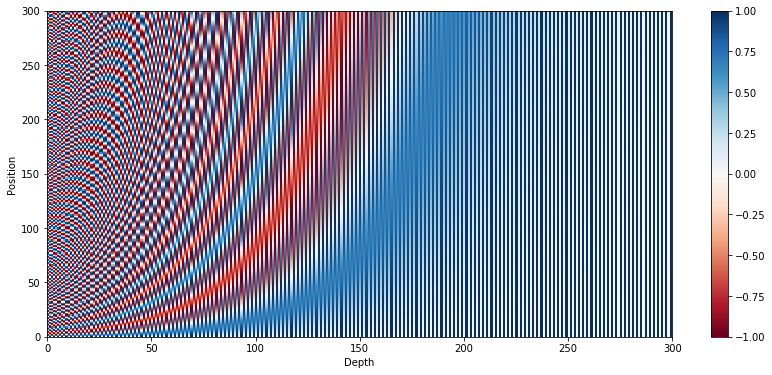

In [20]:
pos_encoding = positional_encoding(300, 300)
print (pos_encoding.shape)

plt.figure(figsize=(14,6))
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 300))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Masking

In [21]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [22]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# Scaled dot product attention

In [23]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True) 

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 

    output = tf.matmul(attention_weights, v) 

    return output, attention_weights

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  
        k = self.wk(k)  
        v = self.wv(v)  

        q = self.split_heads(q, batch_size)  
        k = self.split_heads(k, batch_size)  
        v = self.split_heads(v, batch_size)  

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  

        output = self.dense(concat_attention) 

        return output, attention_weights

In [25]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'), 
      tf.keras.layers.Dense(d_model) 
    ])

In [26]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [27]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                   maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model) #, weights=[embedding_matrix])
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x  


class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)  
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

In [28]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

# Hyperparameters

In [29]:
num_layers = 4
d_model = EMBEDDING_DIM
dff = 512
num_heads = 8

input_vocab_size = encoder.vocab_size + 2
target_vocab_size = encoder.vocab_size + 2
dropout_rate = 0.1

encoder.vocab_size, input_vocab_size,  target_vocab_size, d_model, vocab_size

(64905, 64907, 64907, 128, 64903)

# Optimizer

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

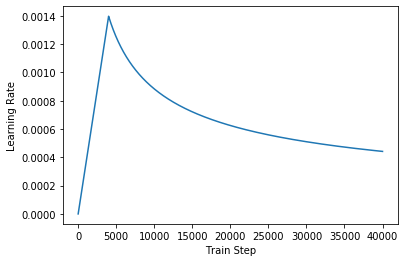

In [31]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
temp_learning_rate_schedule = CustomSchedule(d_model)
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss and metrics

In [32]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# Training and checkpointing

In [33]:
print('vocabulary   size = ', vocab_size)
print('encoder      size = ', encoder.vocab_size)
print('input_vocab  size = ', input_vocab_size)
print('target_vocab size = ', target_vocab_size)

vocabulary   size =  64903
encoder      size =  64905
input_vocab  size =  64907
target_vocab size =  64907


In [34]:
transformer = Transformer(num_layers, 
                          d_model, 
                          num_heads, 
                          dff,
                          input_vocab_size, 
                          target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [35]:
tf.keras.utils.plot_model(transformer, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [36]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

In [37]:
checkpoint_path = "/content/drive/My Drive/ATG/checkpoints1/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [38]:
EPOCHS = 10

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp  = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
      predictions, _ = transformer(inp, tar_inp, 
                                  True, 
                                  enc_padding_mask, 
                                  combined_mask, 
                                  dec_padding_mask)
      loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
            epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

# Evaluate

In [ ]:
def evaluate(inp_sentence, MAX_LENGTH=40):
    start_token = [encoder.vocab_size]
    end_token = [encoder.vocab_size + 1]

    inp_sentence = start_token + encoder.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    decoder_input = [encoder.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        predictions = predictions[: ,-1:, :] 
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == encoder.vocab_size + 1:
              return tf.squeeze(output, axis=0), attention_weights
        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

def pred(sentence):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = encoder.decode([i for i in result if i < encoder.vocab_size])  
    print('Input: {}'.format(sentence))
    print('Predicted title: {}'.format(predicted_sentence))



num_ex = 34
ex = df_train.iloc[num_ex]['abstract']
pred(ex)
print('Real:' + df_train.iloc[num_ex]['title'])

In [ ]:
# Submission

In [ ]:
!ls

In [ ]:
import pandas as pd
submission_data = pd.read_csv('/content/drive/My Drive/ATG/test.csv')
abstracts = submission_data['abstract'].values

In [ ]:
titles = []
for abstract in abstracts:
    result, attention_weights = evaluate(abstract)
    title = encoder.decode([i for i in result if i < encoder.vocab_size])
    titles.append(' '.join(title).replace('<unk>', ''))

In [ ]:
submission_df = pd.DataFrame({'abstract': abstracts, 'title': titles})
submission_df.to_csv('/content/drive/My Drive/ATG/predicted_titles.csv', index=False)

In [ ]:
from nltk.util import ngrams
import numpy as np
import pandas as pd
import pickle
import string


def generate_csv(input_file='predicted_titles.csv',
                 output_file='submission.csv',
                 voc_file='/kaggle/input/title-generation/vocs.pkl'):

    data = pd.read_csv(input_file)
    with open(voc_file, 'rb') as voc_file:
        vocs = pickle.load(voc_file)

    with open(output_file, 'w') as res_file:
        res_file.write('Id,Predict\n')
        
    output_idx = 0
    for row_idx, row in data.iterrows():
        trg = row['title']
        trg = trg.translate(str.maketrans('', '', string.punctuation)).lower().split()
        trg.extend(['_'.join(ngram) for ngram in list(ngrams(trg, 2)) + list(ngrams(trg, 3))])
        
        VOCAB_stoi = vocs[row_idx]
        trg_intersection = set(VOCAB_stoi.keys()).intersection(set(trg))
        trg_vec = np.zeros(len(VOCAB_stoi))    

        for word in trg_intersection:
            trg_vec[VOCAB_stoi[word]] = 1

        with open(output_file, 'a') as res_file:
            for is_word in trg_vec:
                res_file.write('{0},{1}\n'.format(output_idx, int(is_word)))
                output_idx += 1

generate_csv('/content/drive/My Drive/ATG/predicted_titles.csv', 
             '/content/drive/My Drive/ATG/kaggle_pred.csv', 
             '/content/drive/My Drive/ATG/vocs.pkl')

In [ ]:
!wc -l /content/drive/My Drive/ATG/kaggle_pred.csv

In [ ]:
!head /drive/My Drive/ATG/kaggle_pred.csv

In [ ]:
! ls